# ACRA dataset

The 900mb csv dataset deals with all businesses in Singapore, split alphabetically.

In [1]:
import pkg_resources
import scipy
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
import requests
import geopandas as gpd

In [2]:
def getcoordinates(address):
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    resultsdict = eval(req.text)
    if len(resultsdict['results'])>0:
        return resultsdict['results'][0]['LATITUDE'], resultsdict['results'][0]['LONGITUDE']
    else:
        pass

In [8]:
data = pd.read_csv("static_ranked.csv")
mrt_gdf = gpd.GeoDataFrame(data,
                          geometry = gpd.points_from_xy(data.lat, data.long))

In [5]:
import string
for i, letter in enumerate(string.ascii_lowercase):
    if i == 0:
        df = pd.read_csv("./acra/acra-information-on-corporate-entities-"+letter+".csv")
        df = df[["entity_status_description", "postal_code"]]
        df = df[(df["entity_status_description"]=="Live Company") | (df["entity_status_description"]=="Live")].reset_index()
    else:
        temp = pd.read_csv("./acra/acra-information-on-corporate-entities-"+letter+".csv")
        temp = temp[["entity_status_description", "postal_code"]]
        temp = temp[(temp["entity_status_description"]=="Live Company") | (temp["entity_status_description"]=="Live")].reset_index()
        
        df = pd.concat([df, temp])

C:\Users\bryan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df.head()

,index,entity_status_description,postal_code
0,8,Live,680118
1,12,Live,540238
2,17,Live,520438
3,19,Live,730748
4,24,Live Company,409286


In [7]:
addresslist = list(df['postal_code'])
coordinateslist= []
count = 0
failed_count = 0
for address in addresslist:
    try:
        if len(getcoordinates(address))>0:
            count = count + 1
            coordinateslist.append(getcoordinates(address))
    except:
        count = count + 1           
        failed_count = failed_count + 1
        print('Failed to extract',count,'out of',len(addresslist),'addresses')
        coordinateslist.append((0,0))

print('Total Number of Addresses With No Coordinates: ',failed_count)

Failed to extract 94 out of 27317 addresses
Failed to extract 221 out of 27317 addresses
Failed to extract 630 out of 27317 addresses
Failed to extract 1296 out of 27317 addresses
Failed to extract 1395 out of 27317 addresses
Failed to extract 1518 out of 27317 addresses
Failed to extract 1817 out of 27317 addresses
Failed to extract 2015 out of 27317 addresses
Failed to extract 2184 out of 27317 addresses
Failed to extract 2541 out of 27317 addresses
Failed to extract 3580 out of 27317 addresses
Failed to extract 3614 out of 27317 addresses
Failed to extract 3669 out of 27317 addresses
Failed to extract 4508 out of 27317 addresses
Failed to extract 5416 out of 27317 addresses
Failed to extract 6063 out of 27317 addresses
Failed to extract 8407 out of 27317 addresses
Failed to extract 9405 out of 27317 addresses
Failed to extract 9451 out of 27317 addresses
Failed to extract 9464 out of 27317 addresses
Failed to extract 9859 out of 27317 addresses
Failed to extract 10835 out of 27317 a

In [9]:
latlng = np.array(coordinateslist, dtype=object, ndmin=2)
bizData = pd.DataFrame(latlng)
bizData.rename(columns={0: "lat", 1: "lng"}, inplace = True)
bizData.head()

,lat,lng
0,1.37987102781951,103.750647321595
1,1.39044005805872,103.898663984992
2,1.360314073838,103.951590617952
3,1.4453347657703,103.795414343244
4,1.31480522272254,103.893418325845


In [10]:
print(f"No of rows dropped: {failed_count}")
print(f"Total number of rows: {count}")
print(f"Percent of data lost: {failed_count*100/count}%")

No of rows dropped: 49
Total number of rows: 27317
Percent of data lost: 0.17937548047003699%


In [12]:
from shapely.geometry import Point

numberOfKM = 3

def toFloat(n):
    return float(n);

f = list(map(toFloat, bizData.lat))
g = list(map(toFloat, bizData.lng))
circleMall = gpd.GeoDataFrame([
    {'geometry': Point(x, y).buffer(0.008*numberOfKM)}
    for x, y in zip(f,g)])

newdfMall = mrt_gdf.overlay(circleMall, how="intersection")

newdfMall.sort_values(by=['station_code'], inplace = True)

In [13]:
newdfGBM = newdfMall.groupby(["code"])
newdfGBM = newdfGBM.agg({'x': ['count']}).reset_index()
try:
    combinedData.drop(columns=["bizCount"], inplace =True)
except:
    pass
combinedData = pd.merge(data, newdfGBM, on=['code'], how='left')
combinedData.rename(columns={('x', 'count'):"bizCount"}, inplace=True)
combinedData["bizCount"].fillna(0, inplace=True)

C:\Users\bryan\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\bryan\anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='bizCount', ylabel='cluster'>

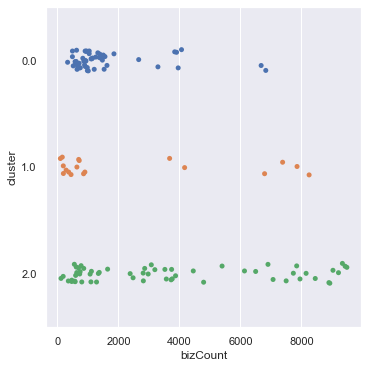

In [15]:
import seaborn as sns
f, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

sns.stripplot(x = 'bizCount', y = "cluster", data = combinedData, orient = "h", ax = axes)

In [17]:
pd.set_option('display.max_columns', None)
combinedData.head()

,name,station_code,code,code2,code3,interchange,NS,SW,CC,EW,NE,BP,CE,DT,PW,TE,PE,CG,SE,totalTapIn,totalTapOut,cluster,postal,x,y,lat,long,subzone,area,region,status,bus_interchange,mrt_interchange,svc,bus count,pop,geometry,groceryCount,mallCount,adj_stations,dist_to_nearest_station,hub,min_dist_to_hub,nearest_hub,bus_rank,pop_rank,hub_dist_rank,adj_count_rank,dist_to_neighbour_rank,pop-bus_rank,bizCount
0,Bukit Panjang,BP6/DT1,BP6,DT1,NaN,True,NaN,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,503763.25,540350.25,0.0,678213,20011.39812,40108.68377,1.379002,103.761535,Gombak,Bukit Batok,West,operational,True,True,"170A,974A,972A,176,180A,190A,963,961M,180,171,...",36,9930.0,POINT (1.379 103.762),23,14,2.0,1.071309,False,5.529046,Jurong East,0.885906,0.536913,0.671141,0.204698,0.610738,-0.348993,614
1,MacPherson,CC10/DT26,CC10,DT26,NaN,True,NaN,NaN,10.0,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,229332.25,218221.75,2.0,378956,34230.01048,34264.54353,1.326150,103.889299,Macpherson,Geylang,Central,operational,False,True,"24,155,135,154,70,80A,137,76,43,158,63A,65,43e...",21,28360.0,POINT (1.326 103.889),37,3,7.0,0.677504,False,6.287145,Raffles Place,0.697987,0.775168,0.805369,0.714765,0.177852,0.077181,3763
2,Tai Seng,CC11,CC11,NaN,NaN,False,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222885.50,225728.50,1.0,534803,34128.79235,35258.74882,1.335142,103.888389,Tai Seng,Hougang,North-East,operational,False,False,"24,70,151,80A,76,58A,43,158,62A,90A,62,90,22,9...",20,13830.0,POINT (1.335 103.888),32,6,4.0,1.004879,False,6.624440,Tampines,0.674497,0.637584,0.838926,0.469799,0.530201,-0.036913,3677
3,Bartley,CC12,CC12,NaN,NaN,False,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87827.50,75543.75,2.0,539788,33214.93397,36072.52553,1.342501,103.880178,Bidadari,Toa Payoh,Central,operational,False,False,"93,158,129,28",4,0.0,POINT (1.343 103.880),20,5,5.0,1.103678,False,7.233564,Raffles Place,0.140940,0.016779,0.892617,0.583893,0.664430,-0.124161,2860
4,Lorong Chuan,CC14,CC14,NaN,NaN,False,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104689.00,100974.75,2.0,554533,31431.40547,37079.94437,1.351612,103.864152,Lorong Chuan,Serangoon,North-East,operational,False,False,"105,58",2,8490.0,POINT (1.352 103.864),28,9,3.0,0.964370,False,7.635612,Raffles Place,0.080537,0.496644,0.919463,0.348993,0.479866,0.416107,1370


In [19]:
combinedData.to_csv("static_ranked_biz.csv")